In [1]:
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.offline as py
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import DataLoader, TensorDataset


In [2]:
# Config & Setup Details
cfg_batch_size  = 50
cfg_max_epochs  = 10
cfg_num_workers = 2

# Learning Config
cfg_split   = 0.8
cfg_seq_len = 180

# Data Config
cfg_data_separator = ","
cfg_data_date_fmt  = "%Y-%m-%d"
cfg_data_url_train = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "Project"
cfg_logger_version = "transformer"


In [3]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [4]:
# Load Data - Parse the Date Column
df_raw = pd.read_csv(cfg_data_url_train, parse_dates=["date"])

print(f"Raw Shape: {df_raw.shape}")
print(df_raw.head())
print("\n********\n")

# Format Date Column to DateTime
df_raw['date'] = pd.to_datetime(df_raw['date'], format=cfg_data_date_fmt)

# Get Sales (Sum across all Stores) Grouped by Date
df_grouped_date = df_raw.groupby(['date'])['sales'].sum().reset_index()
print(f"Grouped by Date Shape: {df_grouped_date.shape}")
print(df_grouped_date)
print("\n********\n")

# Resetting the index
df_sales = df_grouped_date.reset_index()

# Show the New Table
print(f"DF Sales Shape: {df_sales.shape}")
print(df_sales)
print(f"Training Cols: {df_sales.columns}")
print("\n********\n")

df_sales_raw = df_sales.copy()
df_sales_avg = df_sales

df_sales_avg['sales'] = df_sales_avg['sales'].rolling(window=7, min_periods=1).mean()

scaler = MinMaxScaler(feature_range=(-1, 1))

sales_data = df_sales['sales'].values.reshape(-1, 1)
scaled_sales_data = scaler.fit_transform(sales_data)

sales_data_avg = df_sales_avg['sales'].values.reshape(-1, 1)
scaled_sales_data_avg = scaler.fit_transform(sales_data_avg)


Raw Shape: (913000, 4)
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

********

Grouped by Date Shape: (1826, 2)
           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]

********

DF Sales Shape: (1826, 3)
      index       date  sales
0         0 2013-01-01  13696
1         1 2013-01-02  13678
2         2 2013-01-03  14488
3         3 2013-01-04  15677
4         4 2013-01-05  16237
...     ...        ...    ...
1821   1821 2017-12-27  20378
1822   1822 2017-12-28  21885
1823   1823 2017-12-29  23535
1824   1824 2017-12-30  24988
1825   1825 2017-12-31  26420

[1826 rows x 3 columns]
Training Col

In [5]:
df_sales_raw.describe()

,index,date,sales
count,1826.000000,1826,1826.000000
mean,912.500000,2015-07-02 12:00:00.000000256,26125.143483
min,0.000000,2013-01-01 00:00:00,11709.000000
25%,456.250000,2014-04-02 06:00:00,21195.000000
50%,912.500000,2015-07-02 12:00:00,25839.500000
75%,1368.750000,2016-09-30 18:00:00,30779.500000
max,1825.000000,2017-12-31 00:00:00,44936.000000
std,527.265114,NaN,6418.270181


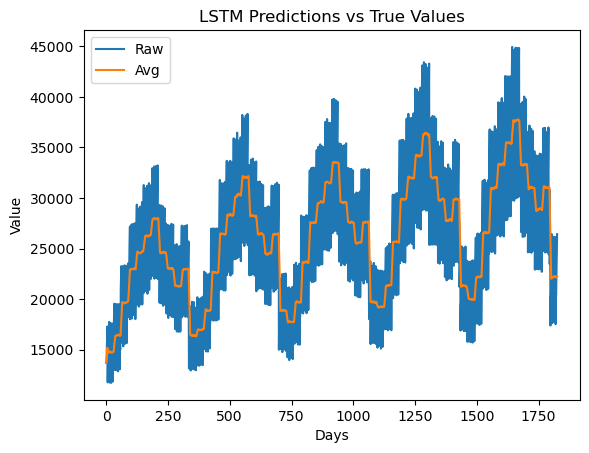

In [6]:
# Plot the true values and the predictions
plt.plot(df_sales_raw["sales"], label="Raw")
plt.plot(df_sales_avg["sales"], label="Avg")
plt.xlabel("Days")
plt.ylabel("Value")
plt.legend()
plt.title("LSTM Predictions vs True Values")
plt.show()

In [7]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Preprocess the historical data
seq_length = 120
x, y = create_sequences(scaled_sales_data_avg, seq_length)

# Split the data into training and testing sets
train_size = int(len(y) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()


In [8]:
from App_LSTM_Model import LSTM_Model

model = LSTM_Model()

In [9]:
summary(model, input_data=torch.Tensor(x_train[0:5]).float())

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_Model                               [5, 1]                    --
├─LSTM: 1-1                              [5, 120, 50]              10,600
├─Linear: 1-2                            [5, 1]                    51
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.36
Input size (MB): 0.65
Forward/backward pass size (MB): 0.24
Params size (MB): 0.04
Estimated Total Size (MB): 0.94

In [10]:
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_train).float(),
                                                torch.Tensor(y_train).float())), 
                                       shuffle=True, 
                                       batch_size=cfg_batch_size, 
                                       num_workers=cfg_num_workers)

xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_test).float(), 
                                              torch.Tensor(y_test).float())), 
                                     shuffle=False, 
                                     batch_size=cfg_batch_size, 
                                     num_workers=cfg_num_workers)


logger = pl.loggers.CSVLogger("lstm-logger", 
                              name="LSTM-Project",
                              version="1.0.0")

In [11]:
trainer = pl.Trainer(logger=logger, 
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.20757150650024414    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.20757150650024414}]

In [13]:
trainer.fit(model, xy_train, xy_val) 


  | Name | Type    | Params
---------------------------------
0 | lstm | LSTM    | 10.6 K
1 | fc   | Linear  | 51    
2 | loss | MSELoss | 0     
---------------------------------
10.7 K    Trainable params
0         Non-trainable params
10.7 K    Total params
0.043     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [14]:
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │   0.0018008498009294271   │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.0018008498009294271}]

In [15]:
torch.save(model.state_dict(), './lstm-model.pth')

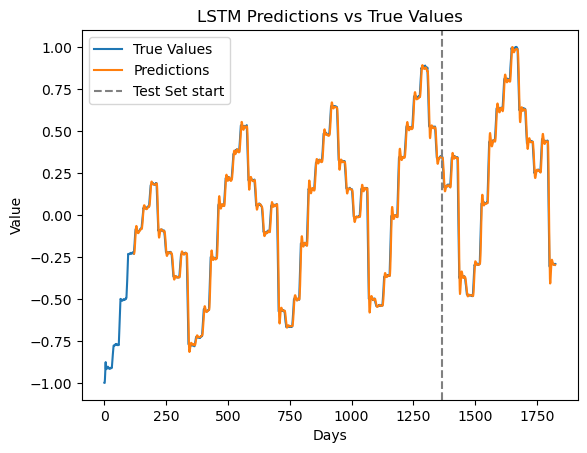

In [16]:
import matplotlib.pyplot as plt

# Concatenate the training and test predictions
with torch.no_grad():
    train_outputs = model(x_train).squeeze().numpy()
    test_outputs = model(x_test).squeeze().numpy()
all_outputs = np.concatenate((train_outputs, test_outputs))

# Calculate the index where the test set starts
test_start_index = len(scaled_sales_data_avg) - len(y_test) - seq_length

# Plot the true values and the predictions
plt.plot(scaled_sales_data_avg, label="True Values")
plt.plot(range(seq_length, seq_length + len(all_outputs)), all_outputs, label="Predictions")
plt.axvline(x=test_start_index, color='gray', linestyle='--', label="Test Set start")
plt.xlabel("Days")
plt.ylabel("Value")
plt.legend()
plt.title("LSTM Predictions vs True Values")
plt.show()